<a href="https://colab.research.google.com/github/touseefashraf/DL_course/blob/main/DL_Lab_2_2_homework_B_(1)_(1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DL Lab 2.2 - Homework - Transfer Learning and Fine-Tuning of Pretrained Models

In the last lab, you built a simple ConvNet, trained it from scratch, added augmentation and regularization techniques, and achieved about 90% accuracy.

In this homework, you will use two techniques for (re-)using the "experience" stored in **pre-trained** models. These techniques are extremely useful if you don't have suffcient data for training a bigger model from scratch. Data such as our images of 10 different classes of flowers. ;-)

In detail, you will use **transfer learning** and **fine-tuning** of a model that was already trained on a very large dataset, namely the *ImageNet ILSVRC* data.

In the end, you will investigate how our ConvNet actually perceives and recognizes the given data by **visualizing feature maps** as well performing **Activation Maximization**.

***

**After completing this homework you will be able to**

- Use **pretrained models** for **transfer-learning** and **fine-tuning**
- alter the **train scope** of specific layers of your models
- **interprete** what your model has learned.

***

**Instructions**

- You'll be using Python 3 in the iPython based Google Colaboratory
- Lines marked by "<font color='green'>`# TODO`</font>" denote the code fragments to be completed by you.
- There's no need to write any other code.
- After writing your code, you can run the cell by either pressing `SHIFT`+`ENTER` or by clicking on the play symbol on the left side of the cell.
- We may specify "<font color='green'>`(≈ X LOC)`</font>" in the "<font color='green'>`# TODO`</font>" comments to tell you about how many lines of code you need to write. This is just a rough estimate, so don't feel bad if your code is longer or shorter.
- If you get stuck, check your Lecture and Lab notes and use the [discussion forum](https://moodle2.tu-ilmenau.de/mod/forum/view.php?id=166458) in Moodle.

Let's get started!

**Note**: Training a ConvNet is a computationally expensive process. Most of the computations can be parallelized very efficently, making them a perfect fit for GPU-acceleration. In order to enable a GPU for your Colab session, do the following steps:
- Click '*Runtime*' -> '*Change runtime type*'
- In the pop-up window for '*Hardware accelerator*', select '*GPU*' 
- Click '*Save*'

# 0 - Test for GPU

Execute the code below for printing the TF version and testing for GPU availability.

In [2]:
#@title Print TF version and GPU stats
import tensorflow as tf
import sys
print('TensorFlow version:', tf.__version__)

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
   raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name), '', sep='\n')
!nvidia-smi

TensorFlow version: 2.9.2
Found GPU at: /device:GPU:0

Sat Nov 26 19:34:18 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   68C    P0    30W /  70W |    312MiB / 15109MiB |      2%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                 

# 1 - Download and Prepare the Data
Execute the cells below to download the data and configure the data generators.

In [3]:
#@title Dataset Downloader

import os
import numpy as np

#@title Dataset Downloader
DEST_PATH = '/tmp/flowers10.zip'

!wget -nv -t 0 --show-progress -O $DEST_PATH 'https://cloud.tu-ilmenau.de/s/WGNk32LRQ847rS6/download/flowers10.zip'
!sleep 1
!unzip -uq $DEST_PATH
!rm  $DEST_PATH

base_dir = 'flowers10/'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'val')

/tmp/flowers10.zip  100%[===================>]  13.10M  37.0MB/s    in 0.4s    
2022-11-26 19:34:19 URL:https://cloud.tu-ilmenau.de/s/WGNk32LRQ847rS6/download/flowers10.zip [13735965/13735965] -> "/tmp/flowers10.zip" [1]


In [4]:
#@title Prepare Data Generators
from tensorflow.keras.preprocessing.image import ImageDataGenerator

batch_size = 128

# All images will be rescaled by 1./255
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.4,
    brightness_range=(.5, 1.5),
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest'
)
val_datagen = ImageDataGenerator(rescale=1./255)

# Flow training images in batches using train_datagen generator
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150,150),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True,
    seed=42
)

num_classes = train_generator.num_classes

# Flow validation images in batches using val_datagen generator
validation_generator = val_datagen.flow_from_directory(
    validation_dir,
    target_size=(150,150),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

train_steps = np.ceil(train_generator.samples / train_generator.batch_size)  # 800 images = batch_size * steps
val_steps = np.ceil(validation_generator.samples / validation_generator.batch_size)  # 200 images = batch_size * steps

Found 800 images belonging to 10 classes.
Found 200 images belonging to 10 classes.


In [5]:
#@title `plot_history()` definition
from matplotlib import pyplot as plt

def plot_history(history):
  fig, (ax1, ax2) = plt.subplots(2,1, sharex=True, dpi=150)
  ax1.plot(history.history['loss'], label='training')
  ax1.plot(history.history['val_loss'], label='validation')
  ax1.set_ylabel('Cross-Entropy Loss')
  ax1.set_yscale('log')
  if history.history.__contains__('lr'):
    ax1b = ax1.twinx()
    ax1b.plot(history.history['lr'], 'g-', linewidth=1)
    ax1b.set_yscale('log')
    ax1b.set_ylabel('Learning Rate', color='g')

  ax2.plot(history.history['accuracy'], label='training')
  ax2.plot(history.history['val_accuracy'], label='validation')
  ax2.set_ylabel('Accuracy')
  ax2.set_xlabel('Epochs')
  ax2.legend()
  plt.show() 

# 2 - Build Models

In [6]:
from tensorflow.keras import layers, Model
from tensorflow.keras.applications import MobileNetV3Small
from tensorflow.keras.optimizers import Adam

## 2.1 - Feature Extraction Model

In [7]:
def build_feature_extraction_model_version_A(input_shape, summary=True):

  FEM=MobileNetV3Small(
    input_shape=input_shape,
    include_top=False,
    weights='imagenet',
  
    )
  FEM.trainable=False
  x=layers.GlobalAvgPool2D()(FEM.output)

  model=Model(FEM.input,x)
  if summary:
    print(model.summary())

  return model

feature_extraction_model = build_feature_extraction_model_version_A( (150,150,3),summary=False )

4334752/4334752 [==============================] - 0s 0us/step


In [8]:
def build_feature_extraction_model_version_B(input_shape, summary=True):

  

  FEM=MobileNetV3Small(
    input_shape=input_shape,
    include_top=False,
    weights='imagenet',
  
    )
  FEM.trainable=False
  input_tensor=layers.Input(shape=input_shape)

  # x=preprocess_model(input_tensor)

  x=FEM(input_tensor)
  
  x=layers.GlobalAvgPool2D()(x)

  model=Model(input_tensor,x)
  if summary:
    print(model.summary())

  return model

feature_extraction_model = build_feature_extraction_model_version_B( (150,150,3),summary=True )

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 MobilenetV3small (Functiona  (None, 5, 5, 576)        939120    
 l)                                                              
                                                                 
 global_average_pooling2d_1   (None, 576)              0         
 (GlobalAveragePooling2D)                                        
                                                                 
Total params: 939,120
Trainable params: 0
Non-trainable params: 939,120
_________________________________________________________________
None


In [9]:
def build_feature_extraction_model_version_C(input_shape, summary=True):

  input_tensor=layers.Input(shape=input_shape)

  FEM=MobileNetV3Small(
    input_shape=input_shape,
    include_top=False,
    weights='imagenet',
    input_tensor=input_tensor
  
    )
  FEM.trainable=False
  

  # x=preprocess_model(input_tensor)

  
  x=layers.GlobalAvgPool2D()(FEM.output)

  model=Model(input_tensor,x)
  if summary:
    print(model.summary())

  return model

feature_extraction_model = build_feature_extraction_model_version_C( (150,150,3),summary=True )

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling_2 (Rescaling)        (None, 150, 150, 3)  0           ['input_4[0][0]']                
                                                                                                  
 Conv (Conv2D)                  (None, 75, 75, 16)   432         ['rescaling_2[0][0]']            
                                                                                                  
 Conv/BatchNorm (BatchNormaliza  (None, 75, 75, 16)  64          ['Conv[0][0]']             

In [10]:
def build_feature_extraction_model_version_D(input_shape, summary=True):

  input_tensor=layers.Input(shape=input_shape)

  # x=layers.preprocessing(input_tensor)

  FEM=MobileNetV3Small(
    input_shape=input_shape,
    include_top=False,
    weights='imagenet',
    input_tensor=input_tensor,
    pooling='avg'
  
    )
  FEM.trainable=False
  

  # x=preprocess_model(input_tensor)

  
  # x=layers.GlobalAvgPool2D()(FEM.output)

  # model=Model(input_tensor,x)
  if summary:
    print(FEM.summary())

  return FEM

feature_extraction_model = build_feature_extraction_model_version_D( (150,150,3),summary=True )

Model: "MobilenetV3small"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling_3 (Rescaling)        (None, 150, 150, 3)  0           ['input_5[0][0]']                
                                                                                                  
 Conv (Conv2D)                  (None, 75, 75, 16)   432         ['rescaling_3[0][0]']            
                                                                                                  
 Conv/BatchNorm (BatchNormaliza  (None, 75, 75, 16)  64          ['Conv[0][0]']    

## 2.2 - Fine-Tuning Model

In [11]:
def build_fine_tuning_model_version_A(input_shape, feature_extraction_model, num_classes, summary=True):


  feature_extraction_model.trainable=True

  output_tensor=layers.Dense(units=num_classes,activation='softmax')(feature_extraction_model.output)

  model=Model(feature_extraction_model.input,output_tensor)

  if summary:
    print(model.summary())

  return model


fine_tuning_model = build_fine_tuning_model_version_A((150,150,3),feature_extraction_model,10, summary=True)

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling_3 (Rescaling)        (None, 150, 150, 3)  0           ['input_5[0][0]']                
                                                                                                  
 Conv (Conv2D)                  (None, 75, 75, 16)   432         ['rescaling_3[0][0]']            
                                                                                                  
 Conv/BatchNorm (BatchNormaliza  (None, 75, 75, 16)  64          ['Conv[0][0]']             

In [12]:
def build_fine_tuning_model_version_B(input_shape, feature_extraction_model, num_classes, summary=True):

# Model are call able on tensor and they return tensors 
  feature_extraction_model.trainable=True

  input_tensor=layers.Input(shape=input_shape)

  output_tensor=feature_extraction_model(input_tensor)

  output_tensor=layers.Dense(units=num_classes,activation='softmax')(output_tensor)

  
  


  model=Model(input_tensor,output_tensor)

  model.compile(
      loss='categorical_crossentropy',
      optimizer=Adam(),
      metrics=['accuracy']
  )
    
  if summary:
    print(model.summary())

  return model


fine_tuning_model = build_fine_tuning_model_version_B((150,150,3),feature_extraction_model,10, summary=True)

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 MobilenetV3small (Functiona  (None, 576)              939120    
 l)                                                              
                                                                 
 dense_1 (Dense)             (None, 10)                5770      
                                                                 
Total params: 944,890
Trainable params: 932,778
Non-trainable params: 12,112
_________________________________________________________________
None


## 2.3 - Callbacks and Training

In [13]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

callbacks = [
    EarlyStopping(
    monitor='val_loss',
    patience=10,
    verbose=1,
    restore_best_weights=True
    ),

    ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,
    patience=5,
    verbose=1,
    min_lr=1e-5
    )
]

Epoch 1/100
7/7 - 22s - loss: 2.1495 - accuracy: 0.2313 - val_loss: 2.5370 - val_accuracy: 0.0750 - lr: 0.0010 - 22s/epoch - 3s/step
Epoch 2/100
7/7 - 6s - loss: 1.4349 - accuracy: 0.5325 - val_loss: 2.6199 - val_accuracy: 0.1000 - lr: 0.0010 - 6s/epoch - 868ms/step
Epoch 3/100
7/7 - 6s - loss: 0.9597 - accuracy: 0.6900 - val_loss: 2.9682 - val_accuracy: 0.1000 - lr: 0.0010 - 6s/epoch - 912ms/step
Epoch 4/100
7/7 - 6s - loss: 0.6985 - accuracy: 0.7550 - val_loss: 3.7590 - val_accuracy: 0.1000 - lr: 0.0010 - 6s/epoch - 890ms/step
Epoch 5/100
7/7 - 6s - loss: 0.5435 - accuracy: 0.8062 - val_loss: 4.0016 - val_accuracy: 0.1000 - lr: 0.0010 - 6s/epoch - 862ms/step
Epoch 6/100

Epoch 6: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
7/7 - 6s - loss: 0.3630 - accuracy: 0.8725 - val_loss: 4.1360 - val_accuracy: 0.1000 - lr: 0.0010 - 6s/epoch - 869ms/step
Epoch 7/100
7/7 - 6s - loss: 0.3569 - accuracy: 0.8725 - val_loss: 4.0593 - val_accuracy: 0.1000 - lr: 1.0000e-04 - 6s/

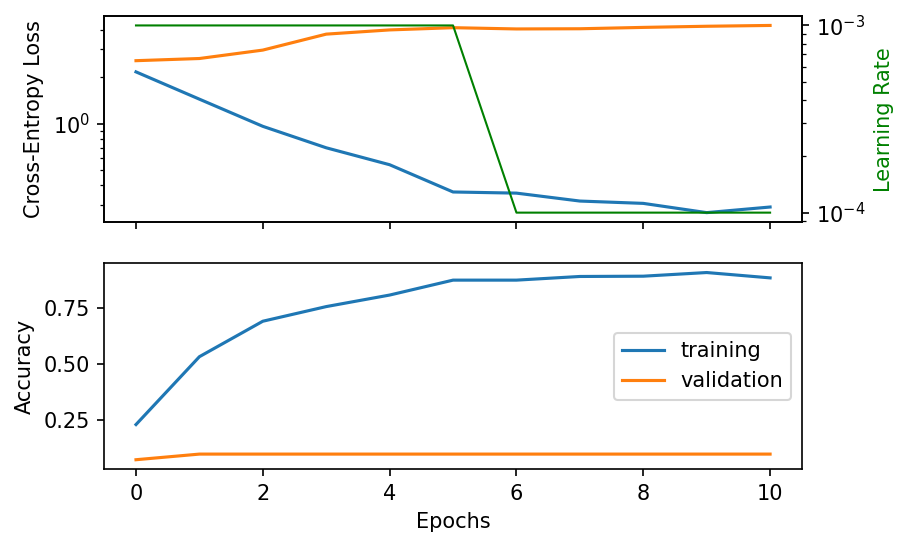

In [14]:
history = fine_tuning_model.fit(
    train_generator,
    steps_per_epoch=train_steps,
    epochs=100,
    validation_data=validation_generator,
    validation_steps=val_steps,
    verbose=2,
    callbacks=callbacks
)

plot_history( history )

#3 - Building ResNet-like Models

In [15]:
def build_simple_resnet(input_shape, num_classes, summary=True):

  

  input_tensor=layers.Input(shape=input_shape)

  z_in=layers.Conv2D(8,7,activation='relu')(input_tensor)

  for filters in [8,16,32,64]:

    x=layers.BatchNormalization()(z_in)
    x=layers.ReLU()(x)
    x=layers.Conv2D(8,3,padding='same')(x)

    z_in=layers.Conv2D(8,1)(x)

    x=layers.Add()([x,z_in])

  x=layers.GlobalAveragePooling2D()(x)

  x=layers.Dense(num_classes,activation='softmax')(x)

  model=Model(input_tensor,x)

  model.compile(
      loss='categorical_crossentropy',
      optimizer=Adam(),
      metrics=['accuracy']
  )



  if summary:
    print(model.summary())

  return model

my_resnet = build_simple_resnet((150,150,3),10,summary=True)

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 144, 144, 8)  1184        ['input_7[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 144, 144, 8)  32         ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                            

Epoch 1/100
7/7 - 9s - loss: 2.2981 - accuracy: 0.1538 - val_loss: 2.3016 - val_accuracy: 0.1000 - lr: 0.0010 - 9s/epoch - 1s/step
Epoch 2/100
7/7 - 6s - loss: 2.1783 - accuracy: 0.1562 - val_loss: 2.3003 - val_accuracy: 0.0900 - lr: 0.0010 - 6s/epoch - 899ms/step
Epoch 3/100
7/7 - 6s - loss: 2.1276 - accuracy: 0.1725 - val_loss: 2.2918 - val_accuracy: 0.1450 - lr: 0.0010 - 6s/epoch - 890ms/step
Epoch 4/100
7/7 - 6s - loss: 2.0930 - accuracy: 0.2013 - val_loss: 2.2884 - val_accuracy: 0.1400 - lr: 0.0010 - 6s/epoch - 886ms/step
Epoch 5/100
7/7 - 6s - loss: 2.0611 - accuracy: 0.2225 - val_loss: 2.2814 - val_accuracy: 0.1650 - lr: 0.0010 - 6s/epoch - 903ms/step
Epoch 6/100
7/7 - 6s - loss: 2.0353 - accuracy: 0.2400 - val_loss: 2.2705 - val_accuracy: 0.1850 - lr: 0.0010 - 6s/epoch - 902ms/step
Epoch 7/100
7/7 - 6s - loss: 2.0167 - accuracy: 0.2488 - val_loss: 2.2613 - val_accuracy: 0.2200 - lr: 0.0010 - 6s/epoch - 892ms/step
Epoch 8/100
7/7 - 6s - loss: 1.9946 - accuracy: 0.2450 - val_loss

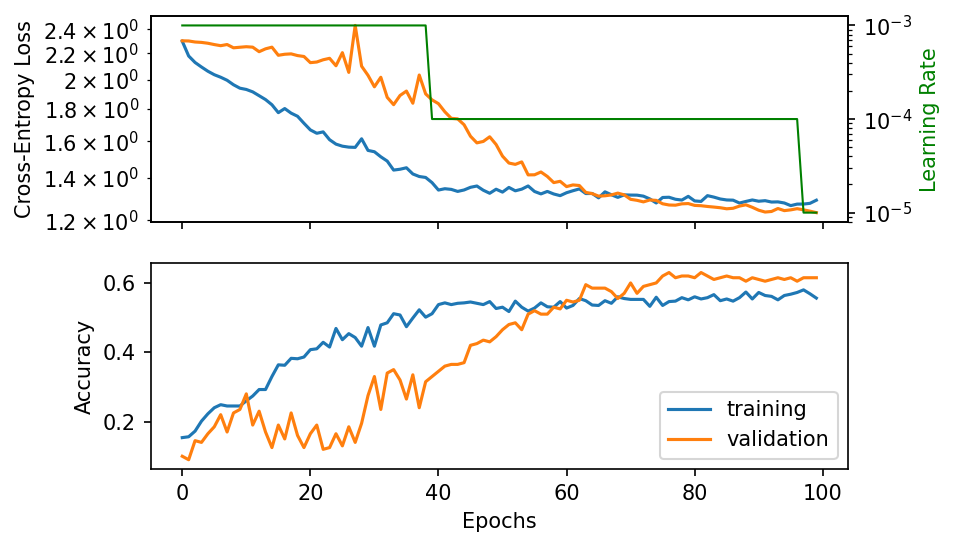

In [16]:
my_resnet_history = my_resnet.fit(
    train_generator,
    steps_per_epoch=train_steps,
    epochs=100,
    validation_data=validation_generator,
    validation_steps=val_steps,
    verbose=2,
    callbacks=callbacks
)

plot_history( my_resnet_history )